# **Content-Based Anime Recommender**

Hello! In this project I analyze anime data based on a 
couple metrics such as score, genre and type. I then visualize anime based on differences in genre, and measure varying score means across total episode counts. Lastly, I end with a content-based recommender that takes into account an anime's genres, episode counts, score, and the number of members that left a review. The model works to compare these features through cosine similarity. This is my first recommender and I look forward to improving upon this in the future by acquiring data that would allow for a collaborative filtering method as well.

### **Credits**
thank to Kaggle user Hernan Valdivieso for providing the data on anime. https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020



In [22]:
#imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, ttest_ind, f_oneway

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [23]:
#Reading the anime dataset into the notebook
anime = pd.read_csv('anime.csv')
anime.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [24]:
#Cleaning. DF will only include TV anime. Meaning OVA's(original animation & videos) and Movies are dropped
#OVA's did not go through a television run and had alternative distributions.
#Movies were dropped because they could also vary in distribution.

anime = anime.dropna()
anime = anime.loc[anime['Type'] == 'TV']
anime = anime.loc[anime['Episodes'] != 'Unknown']
anime = anime.loc[anime['Score'] != 'Unknown']

In [25]:
#Changing dtype of these columns (formerly strings)
anime['Episodes'] = anime['Episodes'].astype(int)
anime['Score'] = anime['Score'].astype(float)

## **The Genre Column**
Currently the genre column is a bit weird to work with and makes genre-specific
analyses difficult to perform. Since the variables are stored as strings rather than a list, an anime labeled as (Action, Adventure) would be categorized differently from one labeled (Adventure, Action). To avoid this, I will iterate through every index in the genre column to identify which anime have which genre in a more tidy format.

In [26]:
# Creating objects that will denote whether or not is classified
# under a particular genre or not, in order to split up the currently
# genre column which is difficult to work with

action = anime['Genres'].str.contains(pat ='Action')
adventure = anime['Genres'].str.contains(pat ='Adventure')
cars = anime['Genres'].str.contains(pat ='Cars')
comedy = anime['Genres'].str.contains(pat ='Comedy')
dementia = anime['Genres'].str.contains(pat ='Dementia')
demons = anime['Genres'].str.contains(pat ='Demons')
drama = anime['Genres'].str.contains(pat ='Drama')
ecchi = anime['Genres'].str.contains(pat ='Ecchi')
fantasy = anime['Genres'].str.contains(pat ='Fantasy')
game = anime['Genres'].str.contains(pat ='Game')
harem = anime['Genres'].str.contains(pat ='Harem')
historical = anime['Genres'].str.contains(pat ='Historical')
horror = anime['Genres'].str.contains(pat ='Horror')
josei = anime['Genres'].str.contains(pat ='Josei')
kids = anime['Genres'].str.contains(pat ='Kids')
magic = anime['Genres'].str.contains(pat ='Magic')
martial_arts = anime['Genres'].str.contains(pat ='Martial Arts')
mecha = anime['Genres'].str.contains(pat ='Mecha')
military = anime['Genres'].str.contains(pat ='Military')
music = anime['Genres'].str.contains(pat ='Music')
mystery = anime['Genres'].str.contains(pat ='Mystery')
parody = anime['Genres'].str.contains(pat ='Parody')
police = anime['Genres'].str.contains(pat ='Police')
psychological = anime['Genres'].str.contains(pat ='Psychological')
romance = anime['Genres'].str.contains(pat ='Romance')
samurai = anime['Genres'].str.contains(pat ='Samurai')
school = anime['Genres'].str.contains(pat ='School')
sci_fi = anime['Genres'].str.contains(pat ='Sci-Fi')
seinen = anime['Genres'].str.contains(pat ='Seinen')
shoujo = anime['Genres'].str.contains(pat ='Shoujo')
shounen = anime['Genres'].str.contains(pat ='Shounen')
slice_of_life = anime['Genres'].str.contains(pat ='Slice of Life')
space = anime['Genres'].str.contains(pat ='Space')
sports = anime['Genres'].str.contains(pat ='Sport')
super_power = anime['Genres'].str.contains(pat ='Super Power')
thriller = anime['Genres'].str.contains(pat ='Thriller')
vampire = anime['Genres'].str.contains(pat ='Vampire')

In [27]:
#Adding the classifiers to the data frame
data = anime[['MAL_ID', 'Name', 'Episodes', 'Score', 'Members']]
data = data.assign(action = action, adventure = adventure, cars = cars, comedy = comedy, dementia = dementia,
               demons = demons, drama = drama, ecchi = ecchi, fantasy = fantasy, game = game, harem = harem,
               historical = historical, horror = horror, josei = josei, kids = kids, magic = magic,
               martial_arts = martial_arts, mecha = mecha, military = military, music = music, mystery = mystery,
               parody = parody, police = police, psychological = psychological, romance = romance,
               samurai = samurai, school = school, sci_fi = sci_fi, seinen = seinen, shoujo = shoujo, shounen = shounen,
               slice_of_life = slice_of_life, space = space, sports = sports, super_power = super_power,
               thriller = thriller, vampire = vampire) 

In [28]:
#Creating the tidy data frame
data_melted = data.melt(id_vars = ['MAL_ID', 'Name', 'Episodes', 'Score', 'Members'], value_vars = ['action', 'adventure', 'cars', 'comedy',
                                                                              'dementia', 'demons', 'drama', 'ecchi',
                                                                              'fantasy', 'game', 'harem', 'historical',
                                                                              'horror', 'josei', 'kids', 'magic',
                                                                              'martial_arts', 'mecha', 'military', 'music',
                                                                              'mystery', 'parody', 'police', 'psychological',
                                                                              'romance', 'samurai', 'school', 'sci_fi',
                                                                              'seinen', 'shoujo', 'shounen', 'slice_of_life',
                                                                              'space', 'sports', 'super_power', 'thriller',
                                                                              'vampire'])

In [29]:
# Currently the data frame includes indeces that simply state an anime does not contain a particular genre 
# (i.e. Action = False)
# Since I'm only interested in which genres an anime DOES contain, I choose to drop the unwanted rows
# This will also help speed up processing later on

data_melted = data_melted.rename(columns = {'variable':'genre'})
data_melted = data_melted.loc[data_melted['value'] != False]
data_melted = data_melted.drop(columns = 'value')
data_melted = data_melted.set_index('MAL_ID')

In [30]:
df = data_melted
df.head()

,Name,Episodes,Score,Members,genre
MAL_ID,,,,,
1,Cowboy Bebop,26,8.78,1251960,action
6,Trigun,26,8.24,558913,action
7,Witch Hunter Robin,26,7.27,94683,action
15,Eyeshield 21,145,7.95,148259,action
18,Initial D Fourth Stage,24,8.15,117929,action


The main dataframe is now complete and ready for further exploration. 

# **Task: Exploration and Visualization**
I am curious to see if perhaps the length that a show has been running could affect its overall scores. My theory is is that the longer anime has been on TV, the less variability we can expect from its scores. For example, does anime generally get better with age? Are "short and sweet" shows preferred over long and drawn out ones?

In [31]:
print('Description of All Anime:')
df.describe()

Description of All Anime:


,Episodes,Score,Members
count,14208.000000,14208.000000,1.420800e+04
mean,29.996622,7.000346,1.415299e+05
std,62.951675,0.761811,2.645266e+05
min,3.000000,2.180000,3.230000e+02
25%,12.000000,6.490000,7.373000e+03
50%,13.000000,7.020000,3.731500e+04
75%,26.000000,7.490000,1.488868e+05
max,1818.000000,9.190000,2.589552e+06


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Score Distributions for All Anime')

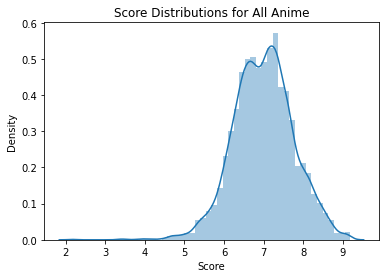

In [32]:
sns.distplot(df['Score']).set_title('Score Distributions for All Anime')

(0.0, 10.0)

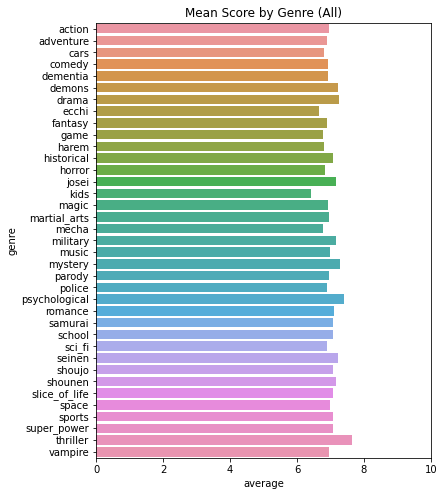

In [33]:
#Checking the mean score, grouped by genre, for all anime

#creating a dataframe that takes into account proportions, rather than raw counts
prop_df = (df['Score']
           .groupby(df['genre'])
           .mean()
           .rename('average', inplace = True)
           .reset_index())

#adjusting the figure size
plt.figure(figsize = (6,8))    

#initializing the barplot
sns.barplot(x = 'average', y = 'genre', data = prop_df).set_title('Mean Score by Genre (All)')

plt.xlim(0, 10)

Text(0.5, 1.0, 'Mean Episode Count by Genre (All)')

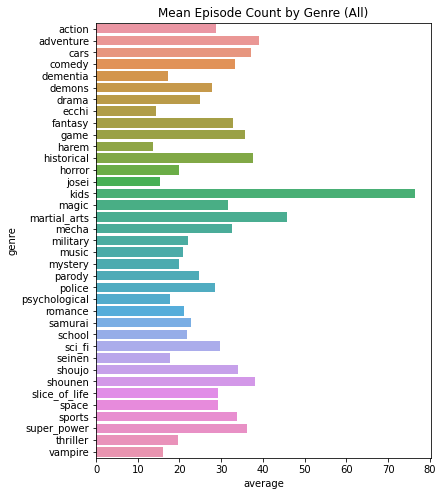

In [34]:
#creating a similar dataframe, but this time using the proportion of episode counts
prop_df2 = (df['Episodes']
           .groupby(df['genre'])
           .mean()
           .rename('average', inplace = True)
           .reset_index())

#adjusting figure size
plt.figure(figsize = (6,8))    

#initialiing the barplot
sns.barplot(x = 'average', y = 'genre', data = prop_df2).set_title('Mean Episode Count by Genre (All)')

This is very interesting. Even having dropped the two extremities, not only are kids anime the lowest rated, but they exceed all other genres in average episode count as well!.

# **Content-based Recommender**
This recommender will use cosine similarities between genre, score, episode count, and the number of member scores as features. Cosine similarity is determined by the angle theta between two entries. A smaller theta indicates more similar anime. I chose this method vs. TF-IDF because as all the information I provide is relevant to the recommendation, I would not want some words to be given less weight due to the nature of TF-IDF.

In [35]:
#selecting only the desired columns
anime = anime[['Name', 'Score','Episodes','Genres', 'Members']]
anime.head()

,Name,Score,Episodes,Genres,Members
0,Cowboy Bebop,8.78,26,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",1251960
2,Trigun,8.24,26,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",558913
3,Witch Hunter Robin,7.27,26,"Action, Mystery, Police, Supernatural, Drama, ...",94683
4,Bouken Ou Beet,6.98,52,"Adventure, Fantasy, Shounen, Supernatural",13224
5,Eyeshield 21,7.95,145,"Action, Sports, Comedy, Shounen",148259


Since all of the text within each of these columns is relevant for recommendation, we will not need to clean the columns much more than just ensuring they are of the same data type for merger. All data points will be combined into one column so as to be compatiple with cosine similarity based recommendations.

In [ ]:
#cleaning and preparing the columns for the recommender

#removing commas
anime['Genres'] = anime['Genres'].str.replace(',','')

#setting to strings
anime['Score'] = anime['Score'].astype(str)
anime['Episodes'] = anime['Episodes'].astype(str)
anime['Members'] = anime['Members'].astype(str)

#kreating a key column that includes all relevant information for recommendation
anime['Keys'] = anime['Genres'] + ' ' + anime['Score'] + ' ' + anime['Episodes'] + ' ' + anime['Members']
anime = anime[['Name', 'Keys']]
anime.head()

In [37]:
#Vectorizing the keys column
count = CountVectorizer()
count_matrix = count.fit_transform(anime['Keys'])

# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [38]:
#setting the dataframe index to be the anime name
anime = anime.set_index('Name')

In [39]:
# creating a Series for the anime titles so they are associated to an ordered numerical
# list I will use in the function to match the indexes
indices = pd.Series(anime.index)

#  defining the function that takes in movie title 
# as input and returns the top 10 recommended movies
def recommendations(title, cosine_sim = cosine_sim):
    
    # initializing the empty list of recommended movies
    recommended_anime = []
    
    # gettin the index of the anime that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar anime
    top_10 = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10:
        recommended_anime.append(list(anime.index)[i])
        
    return recommended_anime

In [40]:
#recommendations for the anime "Naruto"
recommendations('Naruto')

['Naruto: Shippuuden',
 'Dragon Ball Kai (2014)',
 'Dragon Ball Z',
 'Dragon Ball Kai',
 'Dragon Ball Super',
 'Dragon Ball',
 'Rekka no Honoo',
 'Virtua Fighter',
 'Medaka Box',
 'Medaka Box Abnormal']

# **Evaluation**
Comparing these results to those on MyAnimeList.com, we can see that the model is producing fairly similar results! Though MyAnimeList uses a collaborative-filtering method paired with direct user recommendations, my model still manages to produce relevant results. For example, in the case of Naruto, Dragon Ball recommendations seem to dominate the Top 10. This is somewhat to be inspected as the creator of Naruto grew up watching Dragon Ball and was heavily inspired by it. Many similarities can be drawn between the two anime.

# **Conclusion**
Overall this project taught me a few new things and helped me further identify the weaknesses certain data science approaches can bring. I look forward to revisiting this project to see how my thought process may have changed! For now, I will further test this model anecdotally. Ookami to Koushinryou(Spice and Wolf) is perhaps my favorite anime.

In [41]:
#Recommendations for people that like "Ookami to Koushinryou"
recommendations('Ookami to Koushinryou')

['Wellber no Monogatari: Sisters of Wellber Zwei',
 'Tales of Eternia The Animation',
 'Kidou Shinsengumi Moeyo Ken TV',
 'Ookami to Koushinryou II',
 'Granblue Fantasy The Animation',
 'Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka',
 'Madan no Ou to Vanadis',
 'Groove Adventure Rave',
 'Sengoku Night Blood',
 'Seisen Cerberus: Ryuukoku no Fatalités']